In [5]:
import cv2
from cv2.typing import MatLike
import torch
import numpy as np
import glob
from matplotlib import pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import sys
sys.path.append('../')
from personal_tracker.embedder import Embedder
from personal_tracker.metric import MetricType, Metric

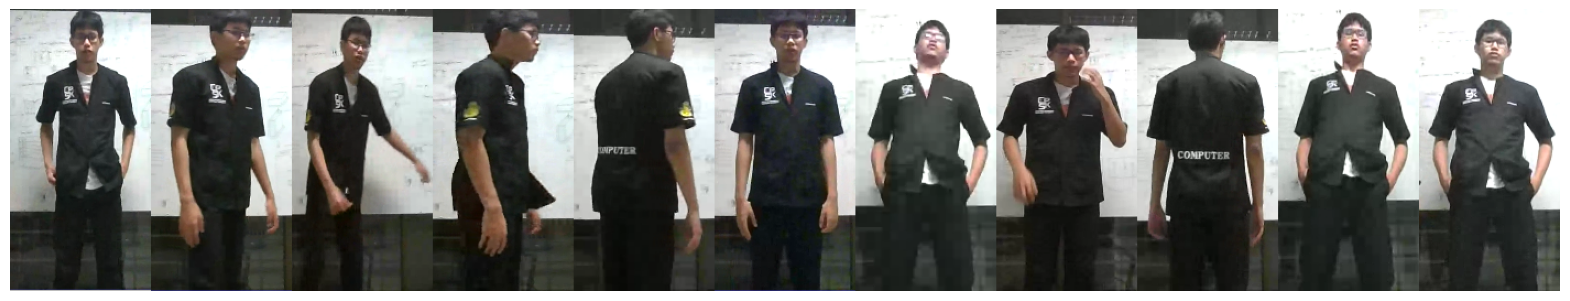

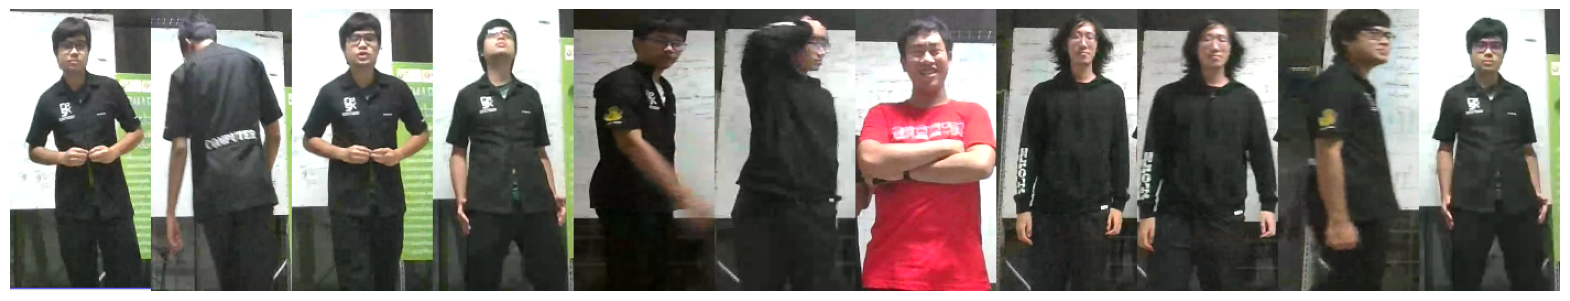

In [36]:
p_targets = glob.glob('../t/1/*')
p_queries = glob.glob('../t/*')
t_images: list[MatLike] = []
t_tensors: list[torch.Tensor] = []
q_images = []
q_tensors = []
for path in p_targets:
    if not path.endswith('.png'):
        continue
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    t_tensors.append(torch.from_numpy(img).permute(2, 0, 1).float())
    t_images.append(img)
for path in p_queries:
    if not path.endswith('.png'):
        continue
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    q_tensors.append(torch.from_numpy(img).permute(2, 0, 1).float())
    q_images.append(img)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.hconcat(t_images))
plt.axis('off');

plt.figure(figsize=(20, 10))
plt.imshow(cv2.hconcat(q_images))
plt.axis('off');

In [32]:
embedder = Embedder()
embedder.model.cpu()
torch.no_grad()
target_features = embedder.model(torch.stack(t_tensors))
query_features = embedder.model(torch.stack(q_tensors))
print(target_features.shape, query_features.shape)

Successfully loaded imagenet pretrained weights from "/home/nhuengzii/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
torch.Size([9, 512]) torch.Size([9, 512])


tensor([1.9610e-01, 9.1528e-01, 1.7928e-01, 1.2674e-01, 5.4151e-05, 0.0000e+00, 7.3038e-01, 1.2318e+00, 9.7218e-02, 2.9226e-01, 0.0000e+00, 0.0000e+00, 2.6888e-03, 1.0366e-01, 9.5003e-01, 0.0000e+00, 4.3337e-01, 0.0000e+00, 3.0158e-02, 1.0669e-02, 5.0754e-01, 1.5941e+00, 1.7301e-01, 1.9058e+00, 5.3293e-02, 7.7361e-01,
        4.0812e-02, 1.9060e+00, 0.0000e+00, 0.0000e+00, 2.5727e-01, 5.9073e-01, 2.7967e+00, 1.7406e+00, 1.4890e+00, 3.4925e-01, 0.0000e+00, 1.0512e+00, 5.9479e-01, 1.7419e-01, 8.6627e-01, 2.6772e-01, 7.1797e-01, 1.2092e+00, 1.6028e+00, 8.3332e-01, 2.1937e-01, 1.0708e+00, 4.3806e-01, 1.1937e+00, 7.1781e-01, 3.8623e-01,
        5.5264e-01, 5.2055e-01, 3.3383e-01, 1.6944e-01, 2.0768e-01, 1.2060e+00, 1.6236e-02, 1.2911e+00, 8.1639e-01, 8.4478e-02, 1.1304e-01, 2.9258e-01, 8.6201e-01, 2.6493e+00, 1.2717e-01, 3.4987e-01, 2.9115e+00, 4.8104e-01, 2.5322e+00, 1.2567e+00, 3.1056e+00, 1.7822e+00, 0.0000e+00, 3.5881e-01, 1.8391e-01, 0.0000e+00,
        4.0869e-02, 2.1385e+00, 9.6162e-

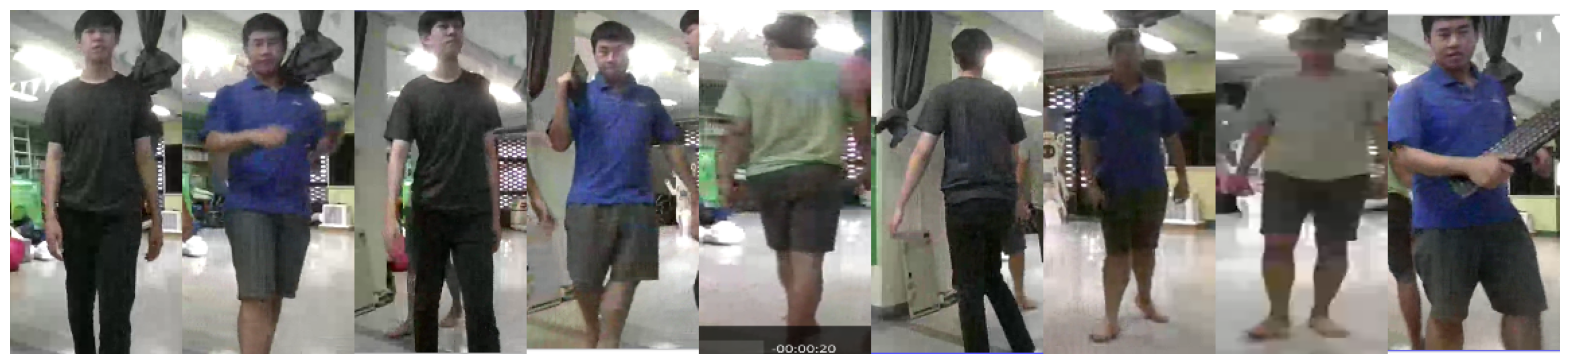

In [35]:
feature_dims = 512

mean = torch.mean(target_features, dim=0)
print(mean)

cosine = torch.cosine_similarity(query_features, mean.unsqueeze(0), dim=1)
print(cosine)

sorted_cosine, indices = torch.sort(cosine, descending=True)

resorted_images = [q_images[i] for i in indices]

plt.figure(figsize=(20, 20))
plt.imshow(cv2.hconcat(resorted_images))
plt.axis('off');


[0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225, 0.7182517647743225]


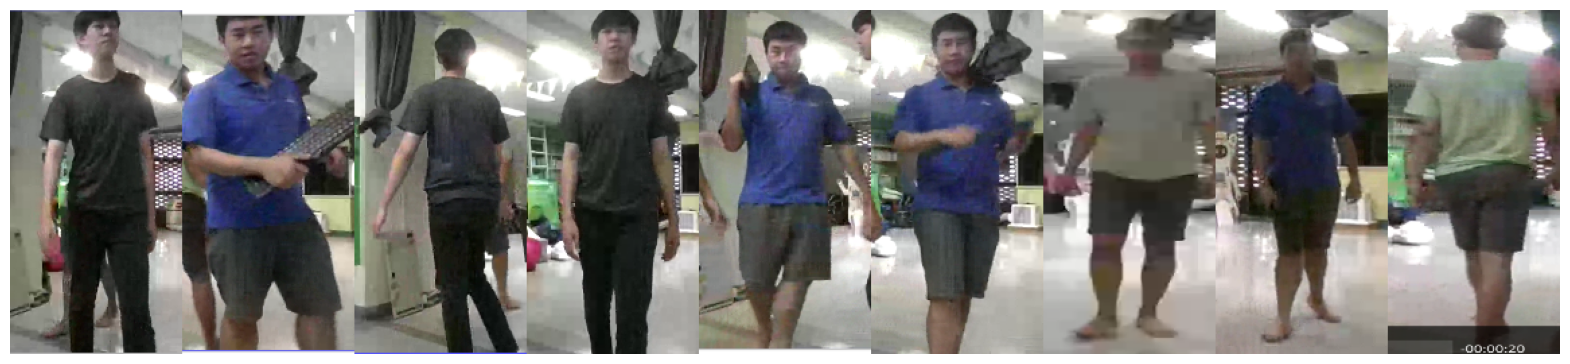

In [34]:
met = Metric(MetricType.COSINE_SIMILARITY)

cosine = []
for i in range(len(query_features)):
    cosine.append(met.rank(target_features, query_features)[1][0])
print(cosine)
sorted_cosine, indices = torch.sort(torch.tensor(cosine), descending=True)

resorted_images = [q_images[i] for i in indices]

plt.figure(figsize=(20, 20))
plt.imshow(cv2.hconcat(resorted_images))
plt.axis('off');


In [ ]:

paths = glob.glob('../t/1/*')
t_images: list[MatLike] = []
t_tensors: list[torch.Tensor] = []
for path in paths:
    if not path.endswith('.png'):
        continue
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    t_tensors.append(torch.from_numpy(img).permute(2, 0, 1).float())
    t_images.append(img)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.hconcat(t_images))
plt.axis('off');

torch.Size([21, 512])
torch.Size([21, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


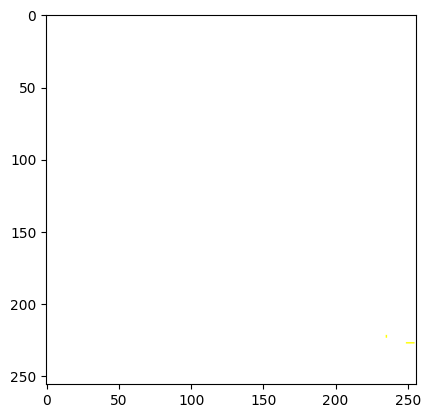

In [ ]:

writer = SummaryWriter()

# Add the features themselves
print(features.shape)
imgs = torch.stack(t_tensors)
print(imgs.shape)

plt.imshow(imgs[0].permute(1, 2, 0))

writer.add_embedding(features.cpu(), label_img=imgs, global_step=0, tag='features')

writer.close()
